In [ ]:
#Figure 5 graph plotting 
#v1.0 version, this is the first consolidation of analysis done so far
#Requires the environment packages found in 23pubenv

In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
import random as rand
from tqdm import tqdm

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
pd.set_option('mode.chained_assignment', None)

In [5]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
#base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path.cwd().parent / Path('Data Sets/2023_01_24_main-set')

images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(79)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))


In [4]:
#So track IDs and corrresponding tracks are found in tracking df, 
#The corresponding points that made the circle are in arcos df, 
#the waves to analze are in waves df, need to go from 
#WaveDF --> arcosDF --> trackingDF 
#Get centroid and radius over time from waveDF, 
#Get trackID inside wavefront from arcosDF, 
#Get track from tracking, then calc radial movement as enter wavefront? 

In [6]:
#Calc a stable centroid: 
#Only looking at clID that hvae waves mapped to them for now...

clIDs = wave_df.clTrackID.values

wave_ex = wave_df[wave_df.clTrackID == clIDs[0]]
arcos_ex =  arcos_df[arcos_df.clTrackID == clIDs[0]]

centroids = np.stack(wave_ex.wave_centroid.values, axis=0)
mean_centroid = (np.mean(centroids[:,0]), np.mean(centroids[:,1]))

In [7]:
#get the tracks that arcos says are inside the wave...
track_collect_all = []
tracks_outside = []

tracks = tracking_df.groupby('track_id')

for i, track in tqdm(tracks): 
    if i in arcos_ex.track_id.unique():
        track_collect_all.append(track)
    else: 
        tracks_outside.append(track[track['timepoint'].between(arcos_ex.timepoint.min()-30, arcos_ex.timepoint.min()+61)])

tracks_in_ex_wave = pd.concat(track_collect_all, ignore_index=True)
tracks_outside_ex_wave = pd.concat(tracks_outside, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 36147/36147 [00:14<00:00, 2533.92it/s]


In [8]:
tracks_group = tracks_in_ex_wave.groupby('track_id')
tracks_calc = []

for track_id, track in tqdm(tracks_group):
    #Get the time, x, and y points, but DO NOT SMOOTH here. 
    #Smoothing for this aligned measurement brings forward the movement in time 
    #This confuses what we are getting at here, so do not smooth in time.
    time = track.timepoint.values*5.0
    
    #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
    coords = np.stack((np.array(track.x.values), np.array(track.y.values)), axis=1)
    lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
    radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
    dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
    velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
    angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
    cis = np.cos(angles)
    radial_velocity = velocity*cis

    #Integrate calcium signal over mean?
    int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())
    
    #Append the relevant parameters to the track: 
    track['radial_dist'] = dist_from_center
    track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
    track['integrated_calcium'] = int_cal
    track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
    track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
    track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
    track['wave_center_distance'] = dist_from_center
    track['max_calcium'] = track['Calcium'].max()
    track['real_time'] = (5.0/60.0)*(track.timepoint.values - arcos_ex.timepoint.min())
    tracks_calc.append(track)
    
ex_first_wave_tracks_calculated_df = pd.concat(tracks_calc, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 3720/3720 [00:13<00:00, 274.98it/s]


In [9]:
tracks_group_outside = tracks_outside_ex_wave.groupby('track_id')
tracks_calc_outside = []

for track_id, track in tqdm(tracks_group_outside):
    #Get the time, x, and y points, but DO NOT SMOOTH here. 
    #Smoothing for this aligned measurement brings forward the movement in time 
    #This confuses what we are getting at here, so do not smooth in time.
    
    #Screen for stubs: 
    if len(track) > 10:
        time = track.timepoint.values*5.0

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(track.x.values), np.array(track.y.values)), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Integrate calcium signal over mean?
        int_cal = np.sum(track['Calcium'] - track['Calcium'].mean())

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['integrated_calcium'] = int_cal
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        track['wave_center_distance'] = dist_from_center
        track['max_calcium'] = track['Calcium'].max()
        track['real_time'] = (5.0/60.0)*(track.timepoint.values - arcos_ex.timepoint.min())
        tracks_calc_outside.append(track)
    
ex_first_wave_outside_tracks_calculated_df = pd.concat(tracks_calc_outside, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 11169/11169 [00:42<00:00, 260.06it/s]


In [10]:
arcos_times = arcos_ex.groupby('timepoint')
tracks_group = ex_first_wave_tracks_calculated_df.groupby('track_id')

tracks_calc_aligned = []
tracks_counted = []
starting_val = []

for t, wave_slice in arcos_times:
    for tr_id in wave_slice.track_id:
        if tr_id in tracks_counted:
            continue
        else:
            track_to_adj = tracks_group.get_group(tr_id)
            #Check if already close to target:
            if track_to_adj.wave_center_distance.values[0] < 40:
                #If so, toss and count it as adjusted, toss track
                tracks_counted.append(tr_id)
            else:
                track_to_adj['aligned_time'] = (5.0/60.0)*(track_to_adj.timepoint.values - t)
                
                #Check to make sure there are at least 2.5min (30frames) before and after calcium pulse inclusion:
                before = track_to_adj.aligned_time[track_to_adj.aligned_time < 0].count()
                after = track_to_adj.aligned_time[track_to_adj.aligned_time > 0].count()
                if before >= 30 and after >= 30:
                    tracks_counted.append(tr_id)
                    tracks_calc_aligned.append(track_to_adj)
                else:
                    tracks_counted.append(tr_id)

tracks_calc_aligned_df = pd.concat(tracks_calc_aligned, ignore_index=True)

In [11]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

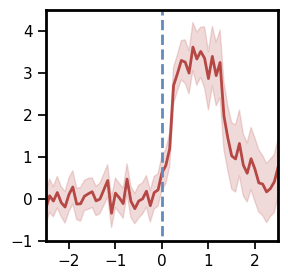

In [13]:
plt.figure(figsize=(3,3))
sns.lineplot(data=tracks_calc_aligned_df, x='aligned_time', y='radial_velocity', color="#B54845")
plt.xlim(-2.5,2.5)
plt.ylim(-1,4.5)
plt.vlines(x=0,ymin=-2,ymax=14, colors='#628BBD',linestyles='dashed')
plt.xlabel('')
plt.ylabel('')
plt.savefig('fig5-im79-w0-ex-aligned-movement.png', dpi=300, bbox_inches='tight')

In [14]:
print('Number of tracks here is {}'.format(str(len(tracks_calc_aligned_df.track_id.unique()))))

Number of tracks here is 1758


In [15]:
tracks_calc_aligned_df['real_time'] = (5.0/60.0)*(tracks_calc_aligned_df['timepoint'] - arcos_ex.timepoint.min())

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

Text(0, 0.5, '')

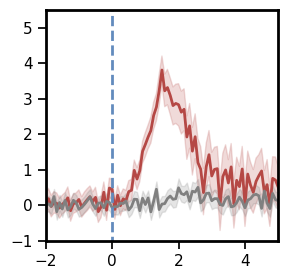

In [16]:
plt.figure(figsize=(3,3))
sns.lineplot(data=ex_first_wave_tracks_calculated_df, x='real_time', y='radial_velocity', color="#B54845")
sns.lineplot(data=ex_first_wave_outside_tracks_calculated_df, x='real_time', y='radial_velocity', color='grey')
plt.xlim(-2.0,5.0)
plt.ylim(-1,5.5)
plt.vlines(x=0,ymin=-2,ymax=14, colors='#628BBD',linestyles='dashed')
plt.xlabel('')
plt.ylabel('')
#plt.savefig('supp5a-aligned-on-wave-start-compare-inside-outside.png', dpi = 300, bbox_inches='tight')

In [17]:
print('Tracks Inside: {}'.format(ex_first_wave_tracks_calculated_df.track_id.nunique()))
print('Tracks Outside: {}'.format(ex_first_wave_outside_tracks_calculated_df.track_id.nunique()))

Tracks Inside: 3720
Tracks Outside: 9907
